In [ ]:
!pip install wandb
!pip install kaggle
!pip install retina-face

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

In [ ]:
!unzip -qq utkface-new.zip

In [ ]:
import torch, torchvision, cv2, os
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

🔸wandb config

In [32]:
batch = 64
epoch = 15
lr = 0.001
width = height = 224

In [ ]:
configs = {
            "learning_rate": lr,
            "epochs": epoch,
            "batch_size": batch,
           }

# wandb.init(project="Age-Estimating-by-Torch", config=configs)
# config = wandb.config
# config.learning_rate = lr

In [ ]:
images = []
ages = []

for image_name in os.listdir('crop_part1')[0:9000]:
    part = image_name.split('_')
    ages.append(int(part[0]))

    image = cv2.imread(f'crop_part1/{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

In [ ]:
images = pd.Series(images, name= 'Images')
ages = pd.Series(ages, name= 'Ages')

df = pd.concat([images, ages], axis= 1)
df.head()

,Images,Ages
0,"[[[157, 121, 71], [159, 123, 73], [162, 126, 7...",2
1,"[[[252, 255, 255], [254, 255, 255], [255, 255,...",10
2,"[[[42, 42, 42], [34, 34, 34], [29, 29, 29], [3...",27
3,"[[[120, 115, 121], [103, 98, 104], [106, 101, ...",80
4,"[[[243, 28, 98], [241, 24, 95], [239, 17, 90],...",1


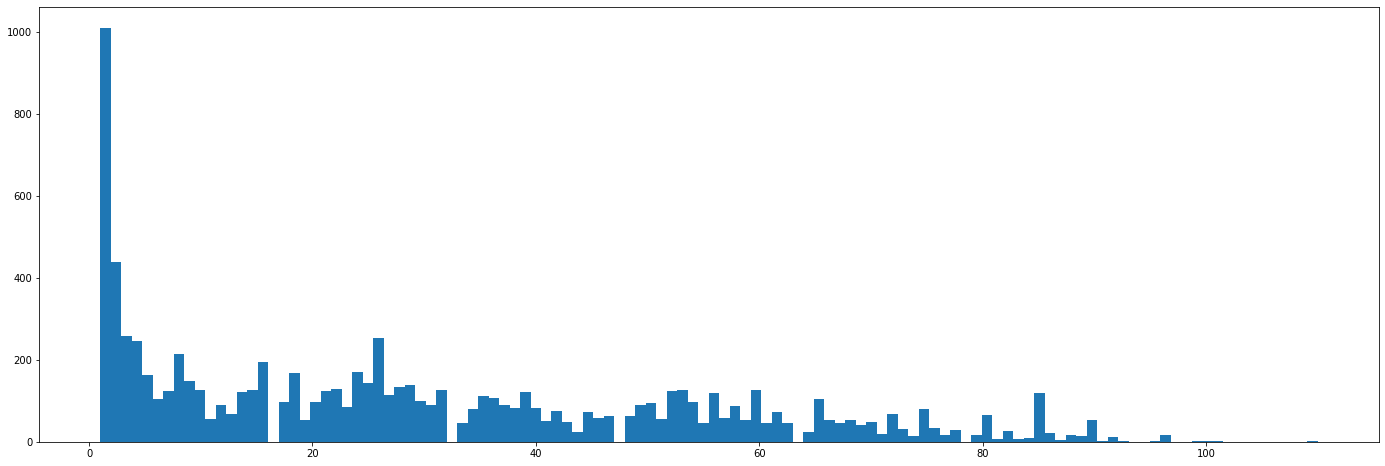

In [ ]:
plt.figure(figsize=(24, 8))
plt.hist(df['Ages'], bins= 116)
plt.show()

In [ ]:
under4 = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4.append(df.iloc[i])

under4 = pd.DataFrame(under4)
under4 = under4.sample(frac= 0.3)

up4 = df[df['Ages'] > 4]

df = pd.concat([under4, up4])

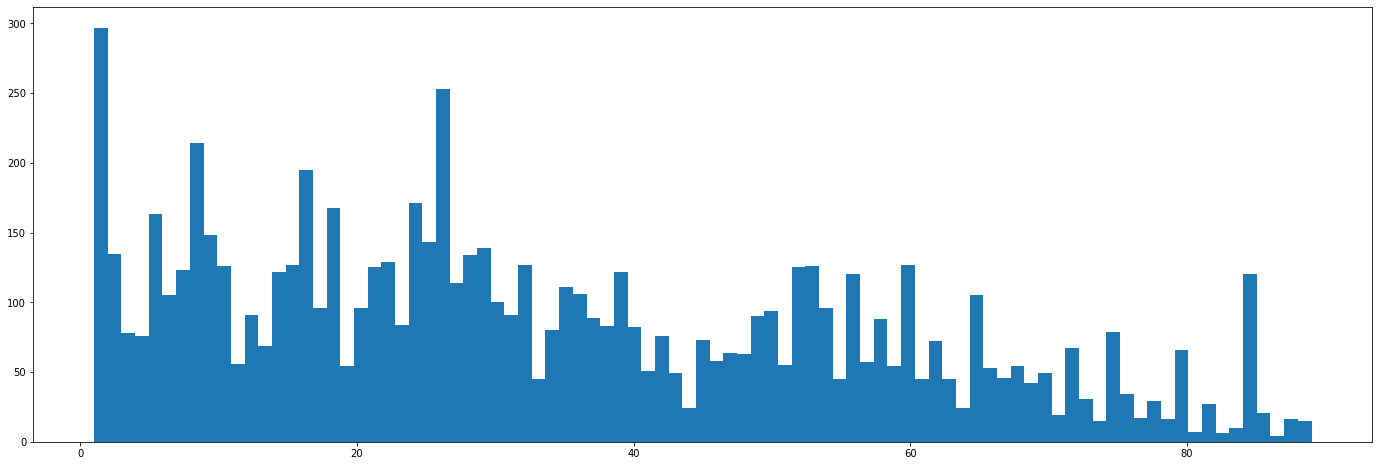

In [ ]:
df = df[df['Ages'] < 90]
plt.figure(figsize=(24, 8))
plt.hist(df['Ages'], bins= 89)
plt.show()

In [33]:
X = []
Y = []

for i in range(len(df)):
    df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i], (width, height))

    X.append(df['Images'].iloc[i])
    Y.append(df['Ages'].iloc[i])

X = np.array(X)
Y = np.array(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [34]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

🔸Class

In [35]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.data = X
        self.target = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y
    
    def __len__(self):
        return len(self.data)

In [36]:
data_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize((70, 70)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                     ])


dataset = MyDataset(X_train, Y_train, data_transform)
dataset = torch.utils.data.DataLoader(dataset, batch_size = 32)

In [37]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, (3, 3), (1, 1), (1, 1))
        self.conv2 = nn.Conv2d(64, 128, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(128, 64, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))

        self.fc1 = nn.Linear(32*17*17, 512)
        self.fc2 = nn.Linear(512, 1)


    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, kernel_size=(2, 2))
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, kernel_size=(2, 2))
      x = F.relu(self.conv4(x))
      x = torch.flatten(x, start_dim=1)
      # print(x.shape)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      # x = torch.softmax(x, dim=1)

      return x

In [38]:
device = torch.device("cuda")
model = Model()
model = model.to(device)
model.train(True)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9248, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

🔸Compile

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()

🔸Train

In [40]:
for ep in range(epoch):
    train_loss = 0.0

    for im, labels in tqdm(dataset):
        im = im.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #forwarding
        y_hat = model(im)

        #backwarding
        loss = loss_function(y_hat,labels.float())
        loss.backward()

        #update
        optimizer.step()

        train_loss += loss

    total_loss  =  train_loss/len(dataset)

    print(f"epoch:{ep} , Loss:{total_loss}")

    # wandb.log({'epochs': ep,
    #   'train_loss': total_loss})

  0%|          | 0/189 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 188/189 [00:13<00:00, 13.94it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 189/189 [00:13<00:00, 13.82it/s]


epoch:0 , Loss:589.35791015625


100%|██████████| 189/189 [00:13<00:00, 13.97it/s]


epoch:1 , Loss:542.8445434570312


100%|██████████| 189/189 [00:13<00:00, 13.97it/s]


epoch:2 , Loss:539.27294921875


100%|██████████| 189/189 [00:13<00:00, 13.95it/s]


epoch:3 , Loss:532.5548095703125


100%|██████████| 189/189 [00:13<00:00, 13.96it/s]


epoch:4 , Loss:530.9267578125


100%|██████████| 189/189 [00:13<00:00, 13.93it/s]


epoch:5 , Loss:530.9439086914062


100%|██████████| 189/189 [00:13<00:00, 13.92it/s]


epoch:6 , Loss:530.90625


100%|██████████| 189/189 [00:13<00:00, 13.63it/s]


epoch:7 , Loss:530.8876953125


100%|██████████| 189/189 [00:13<00:00, 13.95it/s]


epoch:8 , Loss:530.8655395507812


100%|██████████| 189/189 [00:13<00:00, 13.92it/s]


epoch:9 , Loss:530.84423828125


100%|██████████| 189/189 [00:13<00:00, 13.92it/s]


epoch:10 , Loss:530.751220703125


100%|██████████| 189/189 [00:13<00:00, 13.93it/s]


epoch:11 , Loss:530.7990112304688


100%|██████████| 189/189 [00:14<00:00, 13.37it/s]


epoch:12 , Loss:530.8528442382812


100%|██████████| 189/189 [00:13<00:00, 13.94it/s]


epoch:13 , Loss:530.929443359375


100%|██████████| 189/189 [00:13<00:00, 13.95it/s]

epoch:14 , Loss:530.8309326171875


🔸Save weights

In [ ]:
torch.save(model.state_dict(), "age-estimating-torch.pth")

🔸Inference